### Setup & Definition

In [60]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
164682752


In [61]:
class AUNNModel(nn.Module):
    def __init__(
        self, 
        embedding_dim:int, 
        output_dim:int, 
        num_layers:int, 
        hidden_dim:int):        

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__() 
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer =  nn.Linear(self.embedding_dim, self.hidden_dim)

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU()
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    '''
    def encode(self, x: torch.Tensor):

        dim = self.embedding_dim
        assert dim % 2 == 0, "Encoding dimension (dim) must be even."

        # Determine the number of frequencies
        num_frequencies = dim // 2

        # Frequencies corresponding to powers of two, starting from 2^2
        frequency_powers = torch.arange(2, 2 + num_frequencies, dtype=torch.float32, device=x.device)
        frequencies = 2 ** frequency_powers  # Shape: [num_frequencies]

        # Compute the angles: [N, num_frequencies]
        x = x.unsqueeze(1)  # Shape: [N, 1]
        angles = (2 * torch.pi * x) / frequencies  # Broadcasting over x and frequencies

        # Compute the positional encodings
        encoding = torch.zeros(x.size(0), dim, device=x.device)
        encoding[:, 0::2] = torch.sin(angles)  # Even indices: sin
        encoding[:, 1::2] = torch.cos(angles)  # Odd indices: cos

        return encoding
    '''

    def encode(self, x: torch.Tensor): #binary encoding
        dim = self.embedding_dim
        encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
        return encoding

    def forward(self, indices):
        
        x = self.encode(indices)
        x = self.input_layer(x)
        x = x + nn.SiLU()(x)

        for layer in self.layers:
            x = x + layer(x)  # MLP output with skip connection

        x = self.output_layer(x)
        return x

In [62]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [63]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

### Train

In [64]:
# Hyperparameters

embedd_dim = 64
num_layers = 4    # Must be even and at least 2 (bc of skip connections)
hidden_dim = 128   # Size of hidden layers
batch_size = 8192  # Adjust batch size for efficiency
num_epochs = 500

In [65]:
#really long repeated pattern
# text = "abc" * 10_000  # Repeat the sequence to create a long string

#really long random pattern
options = ['|aaa','|bbb','|ccc']
num_sequences = 15_000
num_repeats = num_sequences * len(options)
num_repeats = num_repeats - num_repeats % batch_size # ensure num_repeats is a multiple of batch_size
options = options * num_repeats
random.seed(42)
random.shuffle(options)
text = ''.join(options)
print(len(text))

491520


In [66]:
vocab = sorted(set(text))
token_to_id = {token: id for id, token in enumerate(vocab)}
id_to_token = {id: token for token, id in token_to_id.items()}
token_ids = [token_to_id[char] for char in text]
token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)
indices = torch.arange(len(token_ids)).to(device)

In [67]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, len(vocab), num_layers, hidden_dim).to(device)
print(f"Model has {model.count_params():,} parameters")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
losses = []
accuracies = []

Model has 41860 parameters


In [68]:
# Training Loop
total_steps = len(text) // batch_size
if len(text) % batch_size != 0:
    total_steps += 1

for epoch in tqdm(range(num_epochs)):
    model.train()
    start_idxs = list(range(0, len(text), batch_size))
    # random.seed(epoch)
    # random.shuffle(start_idxs)
    for start_idx in start_idxs:
        end_idx = start_idx + batch_size
        
        inputs = indices[start_idx:end_idx]
        targets = token_ids[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        cur_loss = loss.item()
        losses.append(cur_loss)

        #calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        cur_acc = correct / batch_size
        accuracies.append(cur_acc)

        # recent_avg_loss = sum(losses[-100:]) / 100
        # recent_avg_acc = sum(accuracies[-100:]) / 100
        # print(f"Loss: {recent_avg_loss:.6f}, Accuracy: {recent_avg_acc:.4f}", end="\r")

    avg_loss = sum(losses[-len(start_idxs):]) / len(start_idxs)
    avg_acc = sum(accuracies[-len(start_idxs):]) / len(start_idxs)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.6f}, Average Accuracy: {avg_acc:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] completed, Average Loss: 1.099929, Average Accuracy: 0.4547
Epoch [2/500] completed, Average Loss: 0.977896, Average Accuracy: 0.4991
Epoch [3/500] completed, Average Loss: 0.940851, Average Accuracy: 0.5014
Epoch [4/500] completed, Average Loss: 0.864863, Average Accuracy: 0.5029
Epoch [5/500] completed, Average Loss: 0.878178, Average Accuracy: 0.5018
Epoch [6/500] completed, Average Loss: 0.845822, Average Accuracy: 0.5018
Epoch [7/500] completed, Average Loss: 0.844185, Average Accuracy: 0.5007
Epoch [8/500] completed, Average Loss: 0.861767, Average Accuracy: 0.5012
Epoch [9/500] completed, Average Loss: 0.868849, Average Accuracy: 0.5008
Epoch [10/500] completed, Average Loss: 0.844275, Average Accuracy: 0.5019
Epoch [11/500] completed, Average Loss: 0.829626, Average Accuracy: 0.5043
Epoch [12/500] completed, Average Loss: 0.834060, Average Accuracy: 0.5044
Epoch [13/500] completed, Average Loss: 0.831950, Average Accuracy: 0.5043
Epoch [14/500] completed, Average 

In [69]:
params = {
    'embedding_dim': embedd_dim,
    'output_dim': len(vocab),
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}
save_checkpoint(model, params, optimizer, losses, filename="sequence/checkpoint.pth")

Checkpoint saved with loss 0.7334


In [80]:
model, optimizer, losses = load_checkpoint(filename="sequence/checkpoint.pth")

Checkpoint loaded: loss 0.7334


In [81]:
print(sum(accuracies) / len(accuracies))

0.5871401692708333


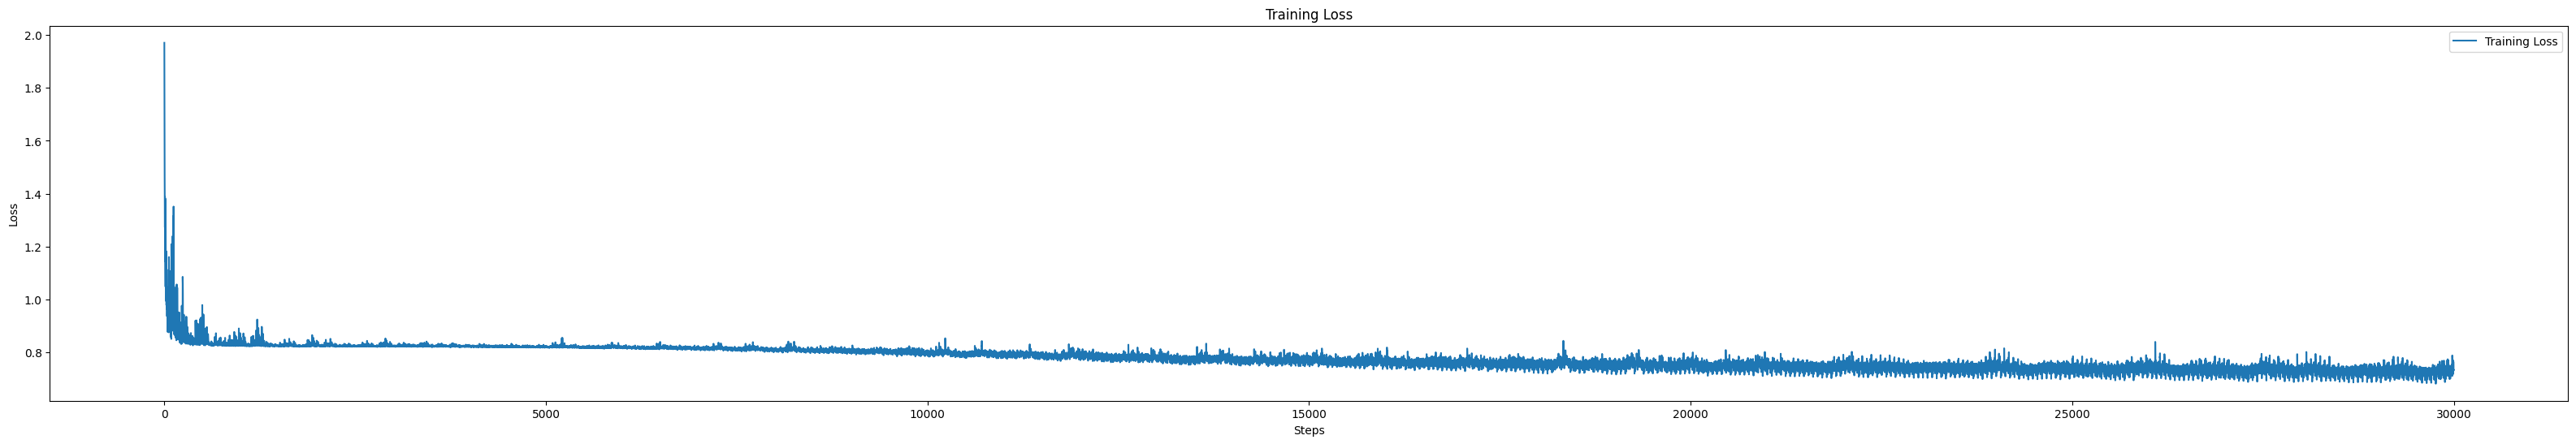

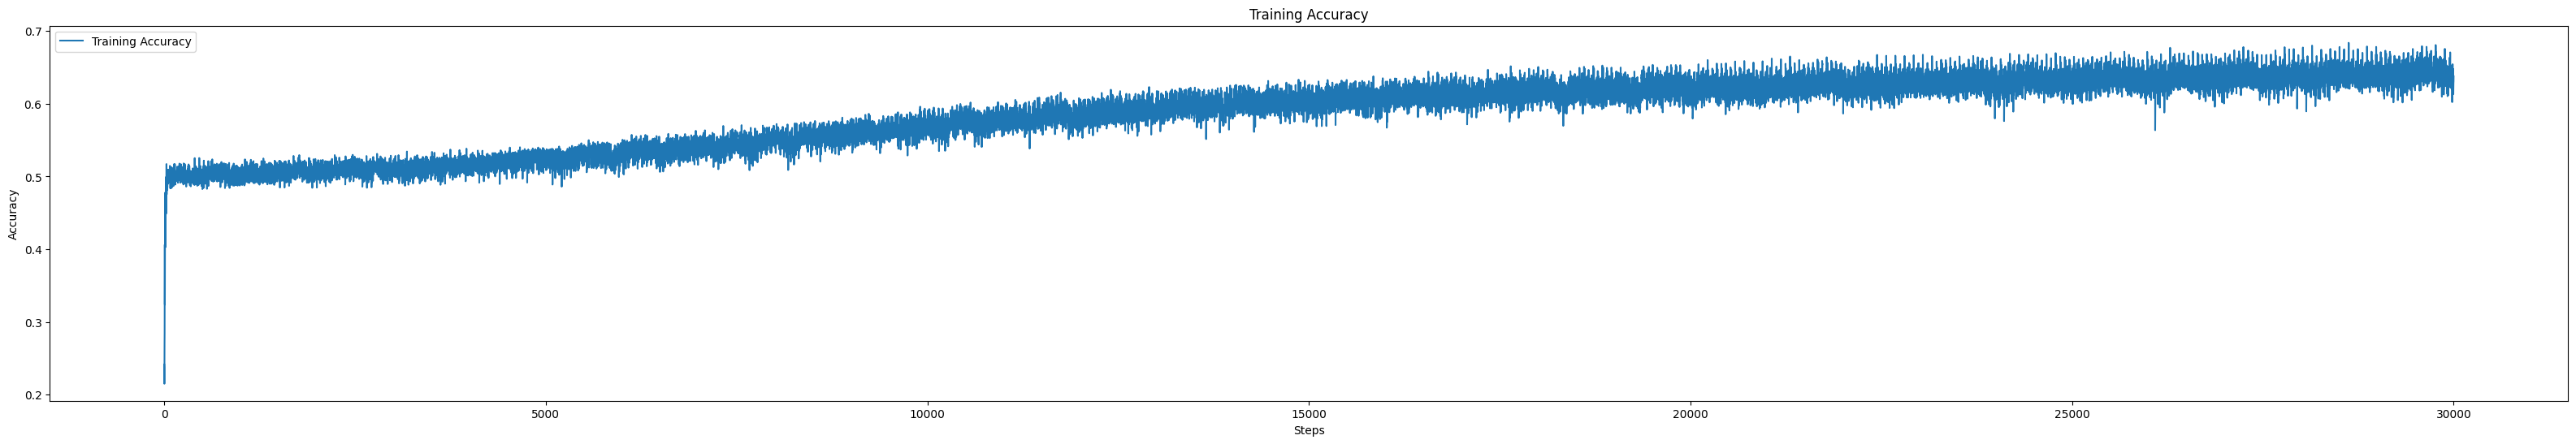

In [82]:
# Plot the loss curves
plt.figure(figsize=(40, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(40, 6))
plt.plot(accuracies, label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [83]:
# Generate Text Function
def generate_text(model, start_index, length):
    model.eval()
    generated_tokens = []
    indices = torch.arange(start_index, start_index + length).to(device)
    with torch.no_grad():
        outputs = model(indices)
        _, predicted = torch.max(outputs, 1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    return ''.join(generated_tokens)

# Generate text starting from the next index after the training data
start_index = 0
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text)

# Generate text starting from the next index after the training data
start_index = len(text) - 50
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
before_end = generated_text[:50]
after_end = generated_text[50:]
print(f"{before_end}_{after_end}")

Generated Text:
|aaa|ccc|aaa|ccc|cac|aaa|aaa|ccc|bbb|aaa|bbb|aaa|ccb|ccc|ccc|caa|bbb|ccc|ccc|ccc|ccc|bbb|aaa|ccc|bbb
Generated Text:
cc|aaa|aaa|aaa|bbb|bbb|aaa|bbb|aaa|aaa|aaa|bbb|bbb_|aaa|aaa|bbb|aaa|aaa|aaa|bbb|aaa|aaa|baa|bbb|bbb|a


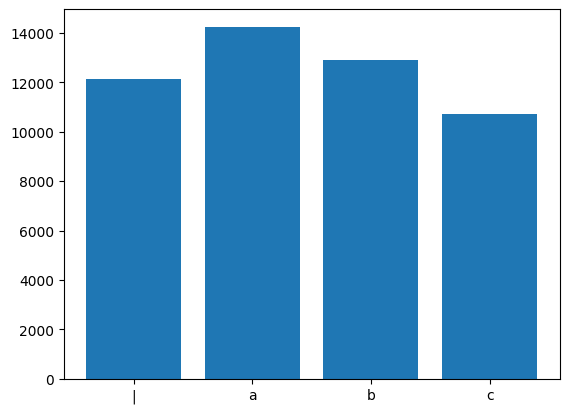

In [84]:
N = len(text) - 1
preds = generate_text(model, start_index=N+1, length=50_000)
count = {}
for char in preds:
    count[char] = count.get(char, 0) + 1

plt.bar(count.keys(), count.values())
plt.show()

In [85]:
N = len(text) - 1

#see value before conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("Original Text:")
print(generated_text) # "|a..."
print("")

#conditioning the model
conditioning_targets = ['|','b']  # Desired tokens at N+1 and N+2, this also works if you use "|c" or "|a" as conditioning_targets
conditioning_positions = [N+1, N+2]
# conditioning_targets = ['c','a','b'] #show conditioning works on discontinuous tokens
# conditioning_positions = [N+2, N+7, N+12]

conditioning_target_indices = [token_to_id[token] for token in conditioning_targets]
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
positions_tensor = torch.tensor(conditioning_positions).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
step = 0

while True:
    conditioning_optimizer.zero_grad()
    outputs = model(positions_tensor)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}, Loss: {loss.item():.6f}")
    #get new outputs
    generated_tokens = []
    outputs = model(positions_tensor)
    predicted = torch.argmax(outputs, dim=1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    print("".join(generated_tokens))
    if generated_tokens == conditioning_targets:
        break

#see value after conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("")
print("Text after conditioning:")
print(generated_text) # "|bbb|..." shows conditioning works because of new values for N+3 and N+4

Original Text:
|aaa|aaa|bbb|aaa|aaa|aaa|bbb|aaa|aaa|baa|bbb|bbb|aaa|aaa|bbb|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|bbb|aaa|aaa|bbb|bbb|bbb|aaa|a

Conditioning Step 1, Loss: 1.666578
|a
Conditioning Step 1, Loss: 0.920492
|a
Conditioning Step 1, Loss: 0.433380
|b

Text after conditioning:
|bbb|bbb|bbb|bbb|bbb|aaa|bbb|bbb|bbb|bbb|bbb|bbb|bbb|aaa|bbb|bbb|aaa|bbb|bbb|bbb|aaa|aaa|bbb|bbb|bbb|bbb|aaa|aaa|bbb|bbb|bbb|bbb|bbb|bbb|bbb|bbb|bbb|b


In [86]:
model, optimizer, losses = load_checkpoint(filename="sequence/checkpoint.pth")

Checkpoint loaded: loss 0.7334


In [87]:
print(token_to_id)

{'a': 0, 'b': 1, 'c': 2, '|': 3}


In [88]:
#assess performance of subsequent conditioning
random.seed(42)
options = ['|aaa','|bbb','|ccc']
sequences = options * 10
random.shuffle(sequences)
new_text = ''.join(sequences) #new text to condition on
print("target:")
print(new_text)


#now we'll condition the model, one letter at a time

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
N = len(text)

for i, letter in enumerate(new_text):

    conditioning_optimizer.zero_grad()

    print("-"*50)

    idx = N + i
    print("conditioning on:")
    print(f"{"_"*i}{letter}{"_"*(len(new_text)-i-1)}")

    #see value before conditioning
    print("output before conditioning:")
    generated_text = generate_text(model, start_index=N, length=len(new_text))
    print(generated_text)

    while True:

        target_ids = [token_to_id[letter]]
        target_tensor = torch.tensor(target_ids, dtype=torch.long).to(device)
        positions = torch.tensor([idx]).to(device)
        outputs = model(positions)
        print(outputs)
        # print(outputs.shape)
        # print(target_tensor.shape)
        loss = criterion(outputs, target_tensor)
        loss.backward()
        conditioning_optimizer.step()
        print(f"Loss: {loss.item():.6f}")

        #see value after conditioning
        print("output after conditioning:")
        generated_text = generate_text(model, start_index=N, length=len(new_text))
        print(generated_text)

        predicted_letter = generated_text[i]
        print(f"{letter} -> {predicted_letter} ... {letter == predicted_letter}")
        if predicted_letter == letter:
            break    
        print('--')

target:
|bbb|ccc|bbb|ccc|bbb|aaa|ccc|aaa|ccc|aaa|aaa|bbb|ccc|aaa|bbb|aaa|bbb|bbb|aaa|ccc|ccc|bbb|bbb|aaa|bbb|ccc|ccc|aaa|aaa|ccc
--------------------------------------------------
conditioning on:
|_______________________________________________________________________________________________________________________
output before conditioning:
|aaa|aaa|bbb|aaa|aaa|aaa|bbb|aaa|aaa|baa|bbb|bbb|aaa|aaa|bbb|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa
tensor([[-5.1244, -8.0417, -3.8578, 48.4877]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Loss: 0.000000
output after conditioning:
|aaa|aaa|bbb|aaa|aaa|aaa|bbb|aaa|aaa|baa|bbb|bbb|aaa|aaa|bbb|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa|aaa
| -> | ... True
--------------------------------------------------
conditioning on:
_b______________________________________________________________________________________________________________________
output before conditioning:
|aaa|aaa|bbb|aaa|aaa|aaa|bbb|aaa|aaa|baa